In [1]:
#from collections import OrderedDict
#import collections
#from collections import Counter

import os
import pickle
import glob
import gzip
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
filename_mesh = 'mesh_list_2021.pickle'
filename_1 = "ds_pair_m2021.csv"

In [3]:
#MeSH 読込
with open(filename_mesh, 'rb') as f:
    mesh_list = pickle.load(f)

#メッシュから　メッシュIDと疾患/症状メッシュ、TreeNumber を取り出す
#疾患メッシュ：Cのうち C22（動物)とC23.888（症状）を除外したもの）＋F03（精神障害）
#症状メッシュ：C23.888
mesh_diseases = [descriptor for descriptor in tqdm(mesh_list) for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]
mesh_symptoms = [descriptor for descriptor in tqdm(mesh_list)  for uid in descriptor[-1] if (uid.startswith("C23.888")==True)]
#さらにメッシュ名だけにする＋重複削除
mesh_diseases= pd.DataFrame(mesh_diseases)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()
mesh_symptoms= pd.DataFrame(mesh_symptoms)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()

len(mesh_list),len(mesh_diseases), len(mesh_symptoms)

  0%|          | 0/29917 [00:00<?, ?it/s]

  0%|          | 0/29917 [00:00<?, ?it/s]

(29917, 4887, 394)

In [4]:
os.chdir('/home/admin_user/デスクトップ/data')
co_occ_pair = pd.read_csv(filename_1)
co_occ_pair =co_occ_pair[['symptom', 'disease', 'co_occurrence']]

In [5]:
#TF-IDF計算

In [6]:
#symptomとペアになるdisease総数
idf_n_i = co_occ_pair.groupby("symptom").count().reset_index()[["symptom", "disease"]].values.tolist()
len(idf_n_i)

385

In [7]:

tfidf_list=[]
N = co_occ_pair["disease"].nunique() #3602 #全疾患の種類数

for pair in tqdm(co_occ_pair.values.tolist()): #co_occ_pair：共起ペアと共起数
    for symptom in idf_n_i: #idf_n_i：symptomとdisease総数
        
        if pair[0]==symptom[0]: #同じsymptomだったら
            
            #バラバシ数式
            W_ij = pair[-1] #diseaseとの共起数
            n_i = symptom[1] #symptomとペアになるdisease総数
            tfidf_value = W_ij*np.log(N /n_i) 
            
            tfidf_list.append([pair[0],  pair[1], W_ij, n_i, tfidf_value])

tfidf = pd.DataFrame(tfidf_list, columns=["symptom","disease","co_occurence", "disease_num", "tf_idf"])
#disease_num：symptomとペアになるdisease総数
tfidf = tfidf.sort_values(by="tf_idf", ascending=False).reset_index(drop=True)


  0%|          | 0/197466 [00:00<?, ?it/s]

In [8]:
tfidf["tf_idf"].sum()

3872199.9626107407

In [9]:
#行列の形にする
pivot_tfidf_df = tfidf.pivot(index='disease', columns='symptom', values='tf_idf').fillna(0)
print(pivot_tfidf_df.sum().sum())

3872199.9626107393


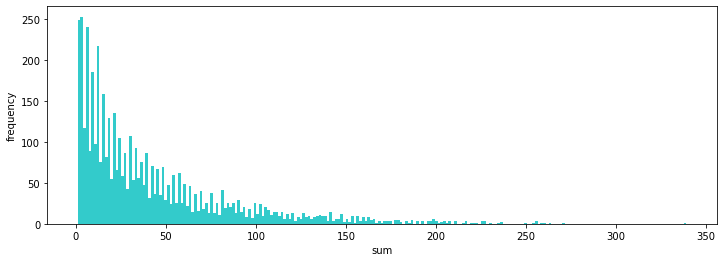

In [10]:
#疾患・症状のTFIDFがゼロより大きい値を取り出した時の可視化

plt.figure(figsize=(12,4))

#TFIDFの数
#plt.subplot(121)
each_disease_sum_vector = [sum(pivot_tfidf_df.loc[disease, :]>0) for disease in pivot_tfidf_df.index]
plt.hist(each_disease_sum_vector,color='c', bins=len(set(each_disease_sum_vector)), alpha=0.8)
plt.xlabel('sum')
plt.ylabel("frequency")
plt.show()

In [11]:
#コサイン類似度　計算

In [12]:
#コサイン算出用データフレームを作る
pre_cosine_df = tfidf.sort_values(['symptom', 'disease'])[['symptom', 'disease',"tf_idf"]].reset_index(drop=True)
pre_cosine_df = pd.pivot_table(pre_cosine_df, index='disease', columns='symptom', values="tf_idf")
pre_cosine_df = pre_cosine_df.fillna(0)#欠損値に0を入れる
#疾患個数
print(len(pre_cosine_df.index))

4679


In [13]:
#疾患ペア(直積ペア)を作る
import itertools
product_list = list(itertools.product(pre_cosine_df.index, pre_cosine_df.index))
print(len(product_list))
print(product_list[0], product_list[1])

21893041
('22q11 Deletion Syndrome', '22q11 Deletion Syndrome') ('22q11 Deletion Syndrome', '46, XX Disorders of Sex Development')


In [14]:
#tfidf行列を疾患（＝行）ごとに分けて直積ペアを作る
vectors = [each_vectors for each_vectors in np.array(pre_cosine_df)]
vectors_list = list(itertools.product(vectors, vectors))

In [15]:
#コサイン類似度

#計算式
def cosine_similarity(x, y):#xとyはベクトルの成分
    return (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))

#直積ペアにコサイン類似度計算を適用 
cosine_similarity_list = []
for disease_pair, vector in tqdm(zip( product_list, vectors_list )):
    cosine_similarity_list.append([disease_pair[0], disease_pair[-1], cosine_similarity(vector[0], vector[1])])

0it [00:00, ?it/s]

In [17]:
#データフレーム化
cosine_df = pd.DataFrame(cosine_similarity_list, columns=["disease_1", "disease_2", "cosine_similarity"])
cosine_df = cosine_df.sort_values("cosine_similarity", ascending=False).reset_index(drop=True)
pivot_cosine_df = cosine_df.pivot(index='disease_1', columns='disease_2', values='cosine_similarity')#.fillna(0)
print(len(cosine_df), len(pivot_cosine_df))

21893041 4679


In [18]:
#インデックスを取得
pivot_index = pivot_cosine_df.index.tolist()

In [19]:
#「同じ疾患同士」「順序が逆になっているだけで同じペアの片方」を削除

#アレイに変換
recent_array = np.array(pivot_cosine_df)

#下三角行列を取得する
#numpy.tril()の引数にnumpy.ndarrayを指定すると、対角線より上の成分をゼロとしたnumpy.ndarrayが返される。
#対角線のコサイン値＝１は不要なので、この対角線箇所も含めてゼロにしたい。
#numpy.tril()の第二引数のkで、境界となる対角線の位置が指定できる（正の値だと上側（右側）、負の値だと下側（左側）に移動する）

recent_array = np.tril(recent_array, k=-1) 

#データフレームにする　対角線含む上の値がゼロになっているか確認
repivot_cosine_df= pd.DataFrame(recent_array, index=pivot_cosine_df.index, columns=pivot_cosine_df.columns)
repivot_cosine_df[:5]

disease_2,22q11 Deletion Syndrome,"46, XX Disorders of Sex Development","ACTH Syndrome, Ectopic",ACTH-Secreting Pituitary Adenoma,"AIDS Arteritis, Central Nervous System",AIDS Dementia Complex,AIDS-Associated Nephropathy,AIDS-Related Complex,AIDS-Related Opportunistic Infections,Abdominal Abscess,...,alpha 1-Antitrypsin Deficiency,alpha-Mannosidosis,alpha-Thalassemia,beta-Mannosidosis,beta-Thalassemia,von Hippel-Lindau Disease,"von Willebrand Disease, Type 1","von Willebrand Disease, Type 2","von Willebrand Disease, Type 3",von Willebrand Diseases
disease_1,,,,,,,,,,,,,,,,,,,,,
22q11 Deletion Syndrome,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"46, XX Disorders of Sex Development",0.00408,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"ACTH Syndrome, Ectopic",0.00000,0.1101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACTH-Secreting Pituitary Adenoma,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"AIDS Arteritis, Central Nervous System",0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#下三角行列のうち、コサイン値ゼロ以外の値の位置を取得
recent_array_index_list = [[value_0,
                            value_1] for value_0, value_1 in zip(list(np.where(recent_array>0)[0]),
                                                                 list(np.where(recent_array>0)[1]))]
print(len(recent_array_index_list))

9343924


In [21]:
#元の（半分ゼロにする前の）行列で同じ位置を指定し、そのインデックス（疾患ペア）と値（コサイン値）を取得
#疾患a, 疾患b, abのコサイン値
repivot_pair = [ [pivot_index[i[0]],
                  pivot_index[i[1]], 
                  repivot_cosine_df.iloc[i[0], i[1]]] for i in tqdm(recent_array_index_list)]

# 作成されるデータは
#    「同じ疾患同士」「順序が逆になっただけの同じペアのうちの片方」「コサイン値ゼロ」これらを除いたデータ

  0%|          | 0/9343924 [00:00<?, ?it/s]

In [22]:
hsdn = pd.DataFrame(repivot_pair, columns=["disease_1", "disease_2", "cosine_similarity"])

In [23]:
print("ds_pair数:", len(tfidf))
print("disease_MeSHの種類数:", len(repivot_cosine_df.index))
print("symptom_MeSHの種類数:", len(idf_n_i), "\n")

print("dd_pairの種類数:", len(hsdn))
print("dd_pairの種類数(O.1<cos):", len(hsdn[hsdn["cosine_similarity"]>0.1]))
print("dd_pairの種類数(O.2<cos):", len(hsdn[hsdn["cosine_similarity"]>0.2]))
print("dd_pairの種類数(O.5<cos):", len(hsdn[hsdn["cosine_similarity"]>0.5]))

cos1 = hsdn[hsdn["cosine_similarity"]>0.1]
print(len(cos1))
print(len(set(cos1["disease_1"].values.tolist() + cos1["disease_2"].values.tolist())))
print("0.1<cosでのcos_max:", cos1["cosine_similarity"].max())
print("0.1<cosでのcos_min:", cos1["cosine_similarity"].min())
print("------------")
cos2 = hsdn[ (hsdn["cosine_similarity"]>0.1) & (hsdn["cosine_similarity"]<1)]
print(len(cos2))
print(len(set(cos2["disease_1"].values.tolist() + cos2["disease_2"].values.tolist())))
print("0.1<cos<1でのcos_max:", cos2["cosine_similarity"].max())
print("0.1<cos<1でのcos_min:", cos2["cosine_similarity"].min())

ds_pair数: 197466
disease_MeSHの種類数: 4679
symptom_MeSHの種類数: 385 

dd_pairの種類数: 9343924
dd_pairの種類数(O.1<cos): 2048497
dd_pairの種類数(O.2<cos): 833831
dd_pairの種類数(O.5<cos): 117718
2048497
4676
0.1<cosでのcos_max: 1.0
0.1<cosでのcos_min: 0.10000000014520655
------------
2048287
4676
0.1<cos<1でのcos_max: 0.9999999999999998
0.1<cos<1でのcos_min: 0.10000000014520655


In [24]:
#保存
hsdn.to_csv("hsdn_m2021.csv", index=False)

In [25]:
# TF-IDFした後で、正のコサイン類似度を持つ疾患-疾患ペアの数は？
print(len(hsdn))

9343924


In [25]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist( hsdn,"disease_1", "disease_2" )
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4679
Number of edges: 9343924
Average degree: 3993.9833


<ipython-input-26-d798651f9263>:11: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)
<ipython-input-26-d798651f9263>:11: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)


ポイントの数は共起頻度数の種類数 865


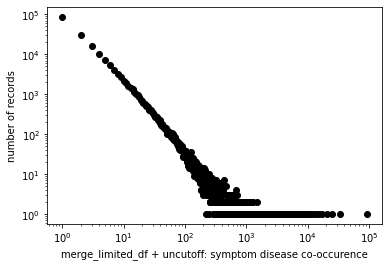

In [26]:
#一文献につき共起する数とその文献数

#両方の軸を対数スケールで設定する必要がある　loglog() 関数を使用
#loglog() 関数
#X 軸と Y 軸の両方に沿って対数スケーリングを行う時使える
#X 軸と Y 軸の対数の底は、basex パラメータと basey パラメータによって設定

a = pd.Series(co_occ_pair["co_occurrence"].value_counts())

plt.scatter(a.index, a, color="black")
plt.loglog(basex=10,basey=10)
plt.xlabel("merge_limited_df + uncutoff: symptom disease co-occurence")
plt.ylabel("number of records",)
print("ポイントの数は共起頻度数の種類数", len(a))
plt.show()

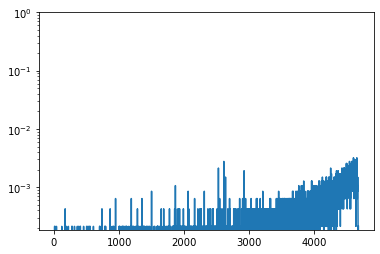

In [27]:
plt.yscale('log')
plt.plot([ degree/len(G.nodes) for degree in nx.degree_histogram(G)])
plt.yticks([0.001, 0.01, 0.1, 1])
plt.show()

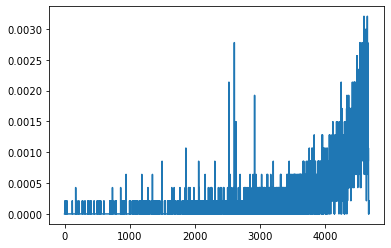

In [28]:
plt.plot([ degree/len(G.nodes) for degree in nx.degree_histogram(G)])
plt.show()

In [29]:
half_d_mesh= G.number_of_nodes()/2
degree = pd.DataFrame(nx.degree(G))
large_degree = degree[degree[1] > half_d_mesh ]
print("disease_MeSH数の半分の数:", G.number_of_nodes(), "/2=", half_d_mesh)
print("disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数:", len(large_degree))
print("その割合:", len(large_degree)/G.number_of_nodes())

disease_MeSH数の半分の数: 4679 /2= 2339.5
disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数: 4428
その割合: 0.9463560589869631


In [30]:
print("最大エッジ数を持つdisease_MeSHとエッジ数:", sorted(G.degree(), key=lambda x: -x[1])[:2])
print("最小エッジ数を持つdisease_MeSHとエッジ数:", sorted(G.degree(), key=lambda x: -x[1])[-2:])

最大エッジ数を持つdisease_MeSHとエッジ数: [('Postoperative Complications', 4675), ('Neoplasms', 4672)]
最小エッジ数を持つdisease_MeSHとエッジ数: [('Fibromatosis, Plantar', 15), ('Alcoholic Korsakoff Syndrome', 9)]


In [32]:
#"Hyponatremia', 'Odontoma" 
SOURCE = "Hyponatremia"
TARGET = "Odontoma"
print("'Hyponatremia'-'Odontoma'パスが存在するか:", nx.has_path(G, source=SOURCE, target=TARGET))
print("その経路, 経路長:", nx.shortest_path(G,  source=SOURCE, target=TARGET), nx.shortest_path_length(G,  source=SOURCE, target=TARGET))
print("Hyponatremia の接続疾患数", [i[1] for i in G.degree() if "Hyponatremia" in i])
print("Odontoma の接続疾患数", [i[1] for i in G.degree() if "Odontoma" in i])

'Hyponatremia'-'Odontoma'パスが存在するか: True
その経路, 経路長: ['Hyponatremia', 'Odontoma'] 1
Hyponatremia の接続疾患数 [4638]
Odontoma の接続疾患数 [3606]


In [33]:
sorted(nx.degree_centrality(G).items(), key=lambda x: -x[1])[:10]

[('Postoperative Complications', 0.9993587002992731),
 ('Neoplasms', 0.9987174005985463),
 ('Disease', 0.9982898674647285),
 ('Diabetes Mellitus', 0.9980761008978195),
 ('Pregnancy Complications', 0.9980761008978195),
 ('Epilepsy', 0.9978623343309105),
 ('HIV Infections', 0.9978623343309105),
 ('Mental Disorders', 0.9978623343309105),
 ('Brain Diseases', 0.9976485677640017),
 ('Cardiovascular Diseases', 0.9976485677640017)]

In [34]:
#違う疾患ペアなのにコサイン値１のデータを取り出す　→ベクトルの状況確認要
hsdn[hsdn["cosine_similarity"] ==1].reset_index(drop=True)[:10]

,disease_1,disease_2,cosine_similarity
0,Atypical Squamous Cells of the Cervix,Asthenozoospermia,1.0
1,Balanitis Xerotica Obliterans,Anal Gland Neoplasms,1.0
2,Birnaviridae Infections,Barth Syndrome,1.0
3,Bluetongue,African Horse Sickness,1.0
4,Body Remains,Barth Syndrome,1.0
5,Body Remains,Birnaviridae Infections,1.0
6,Breast Carcinoma In Situ,Adenocarcinoma in Situ,1.0
7,Bunion,Adenocarcinoma in Situ,1.0
8,Bunion,Breast Carcinoma In Situ,1.0
9,"Carcinoma, Brown-Pearce",Barth Syndrome,1.0


C04 Neoplasms                                                          42
C01 Infections                                                         39
C16 Congenital, Hereditary, and Neonatal Diseases and Abnormalities    29
C17 Skin and Connective Tissue Diseases                                11
C23 Pathological Conditions, Signs and Symptoms                         8
C07 Stomatognathic Diseases                                             8
C15 Hemic and Lymphatic Diseases                                        8
C10 Nervous System Diseases                                             8
C05 Musculoskeletal Diseases                                            8
C13 Female Urogenital Diseases and Pregnancy Complications              7
C22 Animal Diseases                                                     7
C11 Eye Diseases                                                        6
C12 Male Urogenital Diseases                                            6
C06 Digestive System Diseases         

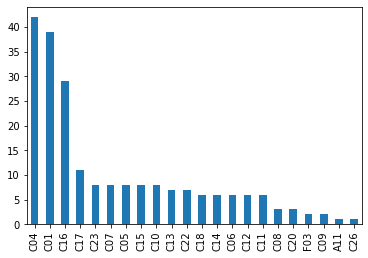

In [35]:
#コサイン値1の疾患ペア（同じ疾患同士は除く）から、ユニークな疾患名を抽出

cos1_disease_name = list(set( [i[0] for i in repivot_pair  if i[-1]==1] + [i[1] for i in repivot_pair if i[-1]==1] ))
#3桁のメッシュ＝メッシュカテゴリー　を抽出
tree_cate = [ [mesh[1], mesh[-1][0]] for mesh in mesh_list for s in mesh[-1] if len(s) == 3 ]

#ユニークな疾患名がどのメッシュカテゴリーに含まれるか調査
cos1_disease_category = []
for  i in cos1_disease_name:
    for mesh in mesh_list:
        if i == mesh[1]:
            cos1_disease_category.extend ([m[:3] for m in mesh[-1]])
            
cos1_disease_category_set = []
for i in cos1_disease_category:
    for mesh in tree_cate:
        if i==mesh[-1]:
            cos1_disease_category_set.append(mesh )

print(pd.Series( pd.DataFrame(cos1_disease_category_set)[1] +" "+ pd.DataFrame(cos1_disease_category_set)[0] ).value_counts())
pd.DataFrame(cos1_disease_category_set)[1].value_counts().plot.bar()
plt.show()

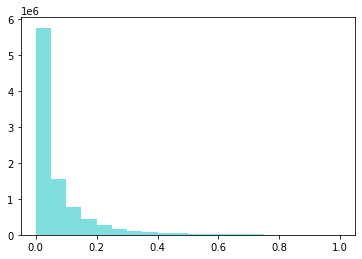

In [36]:
#コサイン値のヒストグラム
plt.hist( pd.DataFrame(repivot_pair)[2], alpha=0.5, bins=20, color='c') 
plt.show()